In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
from pathlib import Path
import json
import random
import re
import uuid
import shutil
import os
from functools import partial
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

random.seed()

In [7]:
project_path = '/datadisk2/qfeng/TextRecognitionDataGenerator'

if project_path not in sys.path:
    sys.path.append(project_path)
    
%cd $project_path
%pwd

/datadisk2/qfeng/TextRecognitionDataGenerator


'/datadisk2/qfeng/TextRecognitionDataGenerator'

**1. Set the parameters: input corpus directory and output image directory**

In [44]:
font_file = '/datadisk2/qfeng/TextRecognitionDataGenerator/trdg/fonts/cn/方正隶书GBK.ttf'
font = 'lishu'

inp_dir = Path('/datadisk2/qfeng/ocr_synthesis/symbol_texts')
outp_path = Path('/datadisk2/qfeng/ocr_synthesis/symbol_outp/{}'.format(font))

if outp_path.exists():
    shutil.rmtree(str(outp_path))
outp_path.mkdir()

In [45]:
inp_texts = []

for p in inp_dir.glob('*'):
    with open(str(p), 'r') as f:        
        for line in f.readlines():
            inp_texts.append(line.strip('\n'))
            
len(inp_texts)

5000

In [46]:
from trdg.generators import CompoundGenerator
from collections import namedtuple

**2. Set the parameters: fix configurations**

In [47]:
conf = namedtuple('Conf', ['width', 'background_type', 'fit', 'line_margin', 'skewing_angle', 'random_skew', 'box_skewing_angle', 'box_random_skew', 'size'])
conf.size = 32
conf.background_type = 1
conf.fit = True
conf.line_margin = 0
conf.skewing_angle = 1
conf.random_skew = True
conf.box_skewing_angle = 1
conf.box_random_skew = True

In [48]:
generator = CompoundGenerator(conf=conf, width=80)

**3. Set the parameters: random configurations**

In [49]:
def gen_image(text):    
    args = namedtuple('Args', ['font', 'texts', 'bold', 'box_margins', 'box_lines', 'alignment'])
    n_texts = 1
    args.texts = [text]   
    args.font = font_file
    args.bold = False
    args.box_margins = (0, 0)
    args.box_lines = [random.randint(0,1), random.randint(0,1), random.randint(0,1), random.randint(0,1)]
    args.alignment = random.randint(0, 1)
    args.draw_box = False
    img, img_locs = generator.gen(args)
    return img, img_locs, args.texts

(80, 32)


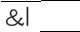

In [50]:
# Test generating one image
img, img_locs, c = gen_image(inp_texts[0])
print(img.size)
img

In [51]:
def save_generated(tag, inp_texts, font):
    gt_dname = outp_path/(tag + '_gt')
    img_dname = outp_path/(tag + '_img')
   
    if gt_dname.exists():
        shutil.rmtree(str(gt_dname))
    gt_dname.mkdir()
        
    if img_dname.exists():
        shutil.rmtree(str(img_dname))
    img_dname.mkdir()
    
    for t in inp_texts:
        img, img_locs, contents = gen_image(t)
        name = str(uuid.uuid4())
        img.save(str((img_dname/(name + '.png'))))
        
        with open(str(gt_dname/(name + '.txt')), 'w') as f:            
            for c, loc in zip(contents, img_locs):
                line = []
                for i_ in loc:
                    line.append(str(round(i_[0], 2)))
                    line.append(str(round(i_[1], 2)))
                line.append('"' + c + '"')
                line.append(font)
                f.write(','.join(line) + '\n')
                

def parallel_save(tag, inp, n_splits, font, n_workers):
    """
    Will generate 2 * n_splits folders (half images and half labels).
    Each folder has bs images or labels.
    """
    with ProcessPoolExecutor(max_workers=n_workers) as ex:
        func = partial(save_generated, font=font)
        step = len(inp)//n_splits
        splits = list(range(0, len(inp), step))
        for i in range(1, len(splits)):
            print(splits[i-1], splits[i])
            ex.submit(func, tag + '_' + str(i), inp[splits[i-1]:splits[i]])

In [52]:
parallel_save(tag='{}'.format(font), inp=inp_texts, n_splits=2, font=font, n_workers=40)

0 2500
